In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# Liner SVM Classification

## Пример кода на базе данных ирисов (цетков)

Следует отметить, что для данной модели критично важно предварительное масштабирование данных

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

p1 = svm_clf.predict([[5.5, 2.5]])
p2 = svm_clf.predict([[4.25, 1.]])
print(p1, p2)

[1.] [0.]


## Soft Margin Classification

### График на отмасштабированных данных

График строится для данных после масштабирования. Цель данного кода показать как графически построить область, разделяющую несколько кластеров

Следует иметь ввиду след. выражение:
x1*w1 + x2*w2 + b = decision_function()
при decision_function() = 0 - является границей. Если значение больше нуля, то данные классифицируются как позитивные, при меньше - как негативные (не учитываем, что границу можно изменить).
 
Центральная линия разделяющая класстеры строится на предположении что:
x1*w1 + x2*w2 + b = 0 (где w - весовые коэффициенты модели, b  - смещение графика)
Таким образом след. код дает точки для построения этой линии:
x0 = np.linspace(xmin, xmax, 200)
decision_boundary1 = -w[0]/w[1] * x0 - b/w[1]

Если при decision_function() = 1 или -1 - то это мягкая граница, после нее данные уже 100% будут определяться как данные определенного класса.

Т.о. принимая ввиду, что x1*w1 + x2*w2 + b = 1 - верхня граница зоны, получаем:
decision_boundary2 =1/w[1] - w[0]/w[1] * x0 - b/w[1]
margin = decision_boundary2 - decision_boundary1 = 1/w[1]

In [3]:
scaler = StandardScaler()
x_scalled = scaler.fit_transform(X)

svm_clf = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf.fit(x_scalled, y)

print()

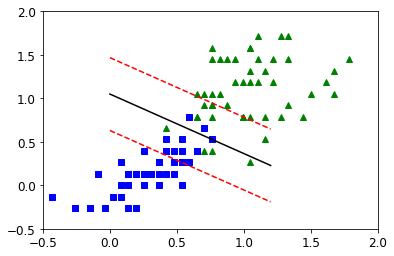

In [4]:
#Покажем исходные даннных (отмасштабированные)
plt.axis([-0.5, 2.0, -0.5, 2.0])
plt.plot(x_scalled[:, 0][y==1], x_scalled[:, 1][y==1], "g^")
plt.plot(x_scalled[:, 0][y==0], x_scalled[:, 1][y==0], "bs")

w = svm_clf.coef_[0] #весовые коэффициенты модели
b = svm_clf.intercept_[0] #параметр смещения 

#построение границы изходи из формулы x1*w1 + x2*w2 + b = 0
x0 = np.linspace(0., 1.2, 100)
x1 = - (w[0] * x0 + b) / w[1]
plt.plot(x0, x1, "k-")

#построение мягких зон изходя изx1*w1 + x2*w2 + b > -1 and x1*w1 + x2*w2 + b < 1
margin = 1 / w[1]
x1_ = x1 + margin
plt.plot(x0, x1_, "r--")
x1_ = x1 - margin
plt.plot(x0, x1_, "r--")

### Обратное масштабирование модели

https://github.com/ageron/handson-ml/issues/250

A trained LinearSVC model basically computes decision_function = w1.x1 + w2.x2 + ...+ wn.xn + b, and if decision_function ≥ 0, then the instance is classified as positive, or else it's classified as negative. x1, x2, ..., xn are the scaled input features and w1, w2, ..., wn are the corresponding weights, and b is the bias term.

It is important to scale the input features before training a support vector machine. That's why we use the StandardScaler. But if we want to plot the decision boundary of the trained LinearSVC on a plot whose axes show the original (unscaled) features, then we need to "unscale" the weights and bias term before plotting the decision boundary. In other words, once we have trained the LinearSVC, we can compute the decision function with w1.x1 + ...+ wn.xn + b, but we would like to be able to compute that same decision function as a function of the unscaled input features (let's call them x'1, x'2, ..., x'n).
So we are looking for the "unscaled" weights w'1, ..., w'n and "unscaled" bias b' such that:

decision_function = w1.x1 + w2.x2 + ...+ wn.xn + b = w'1.x'1 + w'2.x'2 + ... + w'n.x'n + b'

The standard scaler computes xi = (x'i - mean)/scale, so x'i = xi.scale + mean

Therefore:
decision_function = w1.x1 + w2.x2 + ...+ wn.xn + b
= w'1.(x1.scale + mean) + ... + w'n.(xn.scale + mean) + b'
= w'1.scale.x1 + ... + w'n.scale.xn + w'1.mean + ... + w'n.mean + b'

Looking at each input feature xi's weight, we see that: wi = w'i.scale, so w'i = wi/scale.
Moreover, by setting x1, ..., xn to zero, we see that:
b = w'1.mean + ... + w'n.mean + b'
So:
b' = - w'1.mean - ... - w'n.mean + b
= - w1.mean/scale - ... - wn.mean/scale + b
= decision_function(-mean/scale)





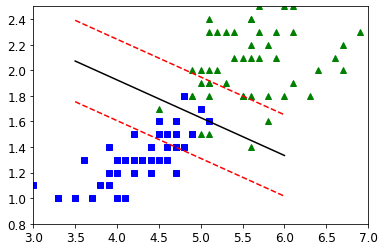

In [5]:
#покажем оригинальные данные (до масштабирования)
plt.axis([3, 7, 0.8, 2.5])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")

w = svm_clf.coef_[0] / scaler.scale_
b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])

#svm_clf.coef_ = np.array([w]) #revise weights into model
#svm_clf.intercept_ = np.array([b]) #revise beis into model

#аналогичные построения тем что выполнены ранее для отмасштабированных данных 
x0 = np.linspace(3.5, 6.0, 100)
x1 = - (w[0] * x0 + b) / w[1]
plt.plot(x0, x1, "k-")

#построение мягких зон изходя из x1*w1 + x2*w2 + b > -1 and x1*w1 + x2*w2 + b < 1
margin = 1 / w[1]
x1_up = x1 + margin
plt.plot(x0, x1_up, "r--")
x1_down = x1 - margin
plt.plot(x0, x1_down, "r--")

### Support vectors

Выделим данных, входящие в support vectors, поскольку по умолчанию этого не происходит

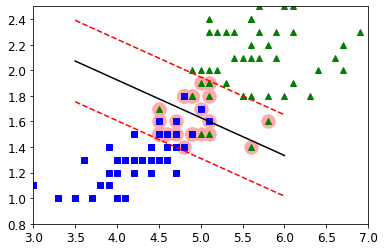

In [6]:
plt.axis([3, 7, 0.8, 2.5])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(x0, x1, "k-")
plt.plot(x0, x1_up, "r--")
plt.plot(x0, x1_down, "r--")

# цель - получить объекты, которые находятся в "мягкой" зоне или определны неверно
t = y * 2 - 1
support_vectors_idx = (t * (X.dot(w) + b) < 1).ravel()
support_vectors = X[support_vectors_idx]

plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=180, facecolors='#FFAAAA')

## Nonlinear SVM Classification

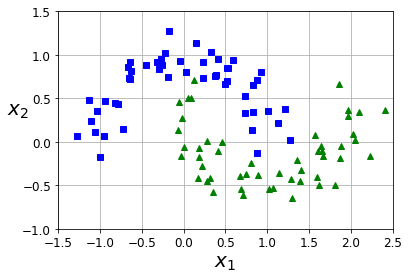

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

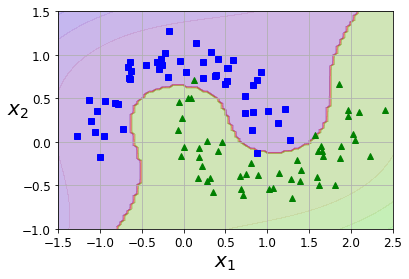

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=5000))
])
polynomial_svm_clf.fit(X, y)

plt.axis([-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

x0s = np.linspace(-1.5, 2.5, 100)
x1s = np.linspace(-1, 1.5, 100)
x0, x1 = np.meshgrid(x0s, x1s)

X_= np.c_[x0.ravel(), x1.ravel()]
y_pred = polynomial_svm_clf.predict(X_).reshape(x0.shape)
y_decision = polynomial_svm_clf.decision_function(X_).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

plt.show()

### Polynomial Kernel 


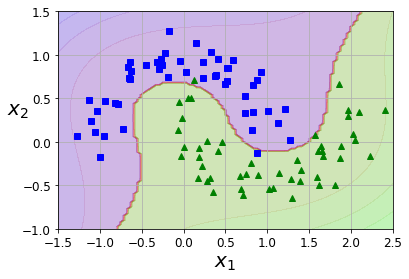

In [9]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

plt.axis([-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

#X_, x0, x1 определены ранее
y_pred = poly_kernel_svm_clf.predict(X_).reshape(x0.shape)
y_decision = poly_kernel_svm_clf.decision_function(X_).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

plt.show()

### Adding Similarity Features

### Gaussian Radial Bias

In [10]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

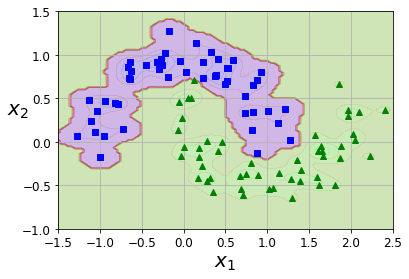

In [11]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=30, C=0.0001)) # 
    ])
rbf_kernel_svm_clf.fit(X, y)

model = rbf_kernel_svm_clf #anothe name to copy-paste the code

plt.axis([-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

model = rbf_kernel_svm_clf

#X_, x0, x1 определены ранее
y_pred = model.predict(X_).reshape(x0.shape)
y_decision = model.decision_function(X_).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

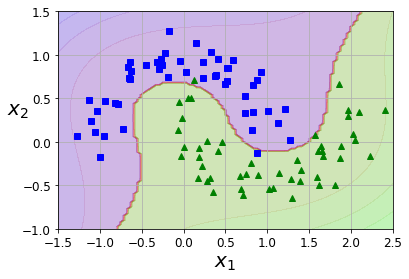

In [12]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
rbf_kernel_svm_clf.fit(X, y)

model = rbf_kernel_svm_clf #anothe name to copy-paste the code

plt.axis([-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

model = rbf_kernel_svm_clf

#X_, x0, x1 определены ранее
y_pred = model.predict(X_).reshape(x0.shape)
y_decision = model.decision_function(X_).reshape(x0.shape)
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

## SVM Regression

In [13]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

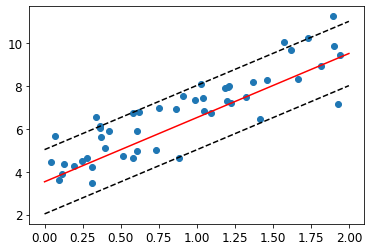

In [14]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

x_ = np.linspace(0., 2., 100).reshape(-1,1)
y_ = svm_reg.predict(x_)

plt.scatter(X, y)
plt.plot(x_, y_, "r-")
plt.plot(x_, (y_ - svm_reg.epsilon), "k--")
plt.plot(x_, (y_ + svm_reg.epsilon), "k--")

полиномиальная регрессия

In [15]:
np.random.seed(42)

m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

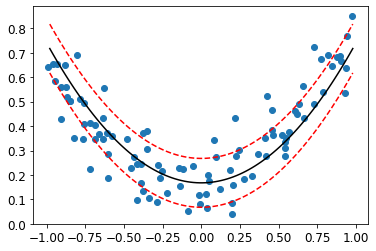

In [16]:
#print(sklearn.__version__)

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

x_ = np.linspace(-1, 1, 102).reshape(-1,1)
x_ = x_[1:-1]
y_ = svm_poly_reg.predict(x_)

plt.scatter(X, y)
plt.plot(x_, y_, "k-")
plt.plot(x_, (y_ - svm_poly_reg.epsilon), "r--")
plt.plot(x_, (y_ + svm_poly_reg.epsilon), "r--")

In [17]:
a = np.array([2,2,2,]).reshape(-1,1)
b = np.arange(3).reshape(-1,1)
print(a)
print(b)
c = a.T.dot(b)
print(c)

[[2]
 [2]
 [2]]
[[0]
 [1]
 [2]]
[[6]]


# Solutions

## 1

What is the fundamental idea behind Support Vector Machines?

Главная идея заключается в том, чтобы построить наиболее широкую зону, разделяющую кластеры. При мягкой зоне разделения SVM ищет компромис между шириной зоны и кол-вом объектов, попавших в мягкую зону.

## 2 

What is a support vector?

Это точки, попадающие в зону или находящие на ее границы. Точки находящиеся за границами на решение модели не влияют: они могут быть перемещены или удалены. Только точки находящиеся в зоне и на ее границах влияют на модель.

## 3

Why is it important to scale the inputs when using SVMs?

SVMs try to fit the largest possible “street” between the classes, so if the training set is not scaled, the SVM will tend to neglect small features

## 4

Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

SVM возращает принадлежности к классу (значения 0 или 1) в зависимости от значения score. Это значение показывает насколько экземпляр далеко от линии разделения кластеров. Косвенно, это значение можно преобразовать в вероятность, если для всего кластера применить сигмоидную функцию.

However, this score cannot be directly converted into an estimation of the class probability. If you set
probability=True when creating an SVM in Scikit-Learn, then after training it will calibrate the probabilities using Logistic Regression on the SVM’s scores (trained by an additional five-fold cross-validation on the training data). This will add the predict_proba() and predict_log_proba() methods to the SVM.

## 5

Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?

Dual form используется при количетсве фьючерсов, привышающем количество элементов данных. Т.о. необходимо использовать стандартную реализацию quadratic programming / primal problem при кол-ве данных большем, чем количество фьючерсов. Однако, dual дает возможность добавить полиномиальные фьючерсы и/или использовать смещение Гаусса для создания новых фьючерсов при этом почти не увеличивая время выполнения и необходимый объем памяти. Так что, чтобы найти золотую середину между кол-вом элементов, количеством имеющихся фьючерсов, необходимости добавления полиномных фьючерсов или фьючерсов образованных смещением Гаусса - необходимо тестировать.

This question applies only to linear SVMs since kernelized can only use the dual form. The computational complexity of the primal form of the SVM problem is proportional to the number of training instances m, while the computational complexity of the dual form is proportional to a number between pow(m,2) and pow(m,3). So  if there are millions of instances, you should definitely use the primal form, because the dual form will be much too slow.

## 6

Say you trained an SVM classifier with an RBF kernel. It seems to underfit the training set: should you increase or decrease γ (gamma)? What about C?

При недообучении следует увеличить паратр гамма потому, что при этом фукнция смещения становится уже, что уменьшает влияние одни экземпляров данных на другие, делая границы более сконцентрированными вокруг отдельных экземпляров. Насчет параметра С - при его увеличении - уменьшается кол-во экземпляров данных, нарушающих границу зоны.

If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase gamma or C (or both).

## 7

How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?

Для отсчета возьмем описание для hard margin из книги. Поскольку для каждого экземпляра данных нужно вычислить значение ζ(i), то придется его добавить в весовые коэффициенты p. Т.о:
- np = n+1+m, где имеется m дополнительных параметров и nc = 2m;
- H дополняется нулями;
- f дополняется гиперпараметром C m раз (поскольку размерность, относительно hard margin увеличена на m раз)
- b дополнительные элементы зануляются
- A имеет увеличенную размерность на m по рядов и на m строк. Справа м столбцов - единичная положительная матрица, под которой вниз на м рядов тоже единичная,но отрицательная матрица. Остальные ячейки заполняются нулями  

## 8 

Exercise: train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

Результат достаточно близкий. Слудет отметить, что SGDClassifier при указанных ниже настройках (использование фукнции потерь ’hinge’ испльзует линейную SVM).

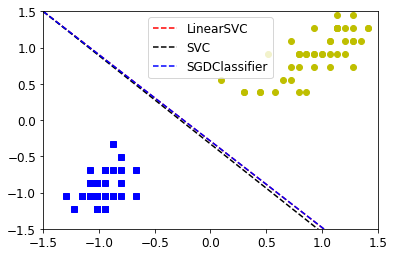

In [18]:
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.linear_model import SGDClassifier


def get_prepared_data():
    iris = datasets.load_iris()
    x = iris["data"][:, (2, 3)]  # petal length, petal width
    y = iris["target"]
    setosa_or_versicolor = (y == 0) | (y == 1)
    x = x[setosa_or_versicolor]
    y = y[setosa_or_versicolor]
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    idx = np.arange(len(x))
    idx = shuffle(idx)
    return scaler, x[idx], y[idx]

def plot_model_line(model, x1_, x2_, color, title):
    x1 = -(x1_ * model.coef_[0][0] + model.intercept_[0]) / model.coef_[0][1]
    x2 = -(x2_ * model.coef_[0][0] + model.intercept_[0]) / model.coef_[0][1]
    plt.plot(np.array([x1_, x1]), np.array([x2_, x2]), color, label=title)
    plt.legend(loc="upper center", fontsize=12)
    
def plot_model_line1(model, zone, color, title):
    x0s = np.linspace(zone[0], zone[1], 100)
    x1s = np.linspace(zone[2], zone[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_= np.c_[x0.ravel(), x1.ravel()]
    y_pred = model.decision_function(X_).reshape(x0.shape)
    plt.contour(x0, x1, y_pred, colors=color[:1], levels=[0], linestyles=[color[1:]])

scale, x, y = get_prepared_data()

area = np.array([-1.5, 1.5, -1.5, 1.5])
c=5.0
m=len(x)
alpha = 1/(m*c)

plt.axis(area)
plt.plot(x[y==0][:, 0], x[y==0][:, 1], "bs")
plt.plot(x[y==1][:, 0], x[y==1][:, 1], "yo")

model = LinearSVC(loss="hinge", C=c, random_state=42)
model.fit(x, y)
plot_model_line(model, -1.5, 1.5, "r--", "LinearSVC")

model = SVC(kernel='linear', C=c, random_state=42)
model.fit(x, y)
plot_model_line(model, -1.5, 1.5, "k--", "SVC")

model = SGDClassifier(loss='hinge', alpha=alpha, max_iter=10000, n_jobs=-1, verbose=0, tol=1e-6, 
                      learning_rate='constant', eta0=0.00001, random_state=42)
model.fit(x,y)
plot_model_line(model, -1.5, 1.5, "b--", "SGDClassifier")


## 9

Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

Будем использовать LinearSVC потому, что этот класс по для многоклассовой классификации использует one-vs-all

In [19]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
x = mnist["data"]
y = mnist["target"]

In [20]:
y_ = y.astype(np.uint8)
x_train =  x[:60000]
y_train = y_[:60000]
x_test  =  x[60000:]
y_test  = y_[60000:]

In [21]:
from sklearn.metrics import accuracy_score

model1 = LinearSVC(random_state=42)
model1.fit(x_train, y_train)

/home/mbm/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [22]:
predict1  = model1.predict(x_train)
accuracy1 = accuracy_score(y_train, predict1)
print("accuracy:", accuracy1 * 100, "%")

accuracy: 87.33 %


Посмотрим как изменится результат после предварительного **масштабирования** данных

In [23]:
scale = StandardScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled  = scale.transform(x_test)

In [24]:
model2 = LinearSVC(random_state=42)
model2.fit(x_train_scaled, y_train)

/home/mbm/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [41]:
predict2  = model2.predict(x_train_scaled)
accuracy2 = accuracy_score(y_train, predict2)
print("accuracy: {0:.3}%".format(accuracy2*100))

accuracy: 92.3%


Попробуем добиться лучше производительности на классе SVM с использованием kernel=rbf

In [47]:
model3 = SVC(kernel="rbf", random_state=42)
model3.fit(x_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [48]:
predict3  = model3.predict(x_train_scaled)
accuracy3 = accuracy_score(y_train, predict3)
print("accuracy: {0:.3}%".format(accuracy3*100))

accuracy: 94.6%


Найдем оптимальные гиперпараметры используя RandomSearchCV

In [93]:
from scipy.stats import uniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distr = {"gamma": reciprocal(0.0000001, 1), "C": uniform(0.1, 20)}
search_cv = RandomizedSearchCV(model3, param_distr, n_iter=50, cv=5, n_jobs=-1,
                               verbose=2,random_state=42, return_train_score=True)
search_cv.fit(x_train_scaled[:3000], y_train[:3000])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 43.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=42,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5fddf00c50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5fddf00f98>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True, scoring=None, verbose=2)

In [95]:
print(search_cv.best_estimator_)
print("accuracy: {0:.3}%".format(search_cv.best_score_*100))

SVC(C=6.184844859190754, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0004712973756110781, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)
accuracy: 91.8%


Снова обучим SVC с полученными гиперпараметрами

In [103]:
c_, gamma_ = search_cv.best_estimator_.C, search_cv.best_estimator_.gamma

model4 = SVC(kernel="rbf", random_state=42, C=c_, gamma=gamma_)
model4.fit(x_train_scaled[:10000], y_train[:10000])

SVC(C=6.184844859190754, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0004712973756110781, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)

In [104]:
predict4  = model4.predict(x_train_scaled)
accurac4 = accuracy_score(y_train, predict4)
print("accuracy: {0:.3}%".format(accurac4*100))

accuracy: 95.0%


Ха-ха... всего на 0.4% больше чем до использования RandomizedSearchCV.
Попробуем обучить модель на всех данных.

In [106]:
model5 = SVC(kernel="rbf", random_state=42, C=c_, gamma=gamma_)
model5.fit(x_train_scaled, y_train)

SVC(C=6.184844859190754, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0004712973756110781, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)

In [107]:
predict5  = model5.predict(x_train_scaled)
accurac5  = accuracy_score(y_train, predict5)
print("accuracy on train set: {0:.3}%".format(accurac5*100))

accuracy on train set: 98.7%


In [108]:
predict5_test  = model5.predict(x_test_scaled)
accurac5_test  = accuracy_score(y_test, predict5_test)
print("accuracy on test set: {0:.3}%".format(accurac5_test*100))

accuracy on test set: 96.8%


Результат показывает что модель немного переобучена на обучающем наборе. Решение - запустить поиск параметров на большем размере данных, с большим значением n_iter и т.п.

## 10 

Train an SVM regressor on the California housing dataset.

### Подготовим данные для обучения и тестирования

In [151]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
housing_x = housing["data"]
housing_y = housing["target"]

Подготовим данные для наборов обучения и тестирования

In [155]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

idx = np.arange(len(housing_x))
idx = shuffle(idx)

x_ = housing_x[idx]
y_ = housing_y[idx]

x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

def print_errors(model):
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)
    train_err = mean_squared_error(y_train, y_train_pred)
    test_err  = mean_squared_error(y_test,  y_test_pred)
    print("train mean squared error:", train_err)
    print("test  mean squared error:", test_err)

### LinearSVR (по умолчанию)

In [178]:
from sklearn.svm import LinearSVR

svr1 = LinearSVR(random_state=42, max_iter=5000)
svr1.fit(x_train, y_train)

print_errors(svr1)

train mean squared error: 0.9298948701407039
test  mean squared error: 0.4991822554463714


### SVR (по умолчанию)

In [159]:
from sklearn.svm import SVR

svr2 = SVR()
svr2.fit(x_train, y_train)

print_errors(svr2)

train mean squared error: 0.34078372161433435
test  mean squared error: 0.33908104130110944


Полученная ошибка существенно меньше чем при использовании LinearSVR. Т.о. ошибка в последней модели порядка 3400$. Попробуем ее уменьшить выполнив поиск оптимальных гиперпараметров для послденей модели.

### Поиск гиперпараметров для SVR

In [137]:
from scipy.stats import uniform, randint,reciprocal
from sklearn.model_selection import RandomizedSearchCV

#param_distr = [{"gamma": reciprocal(0.0001, 0.1), "C": uniform(0.1, 5)},
#               {"kernel": ['poly'], "degree": randint(2, 6), "C": uniform(0.1, 5)}]

param_distr = {"C": uniform(0.1, 2)} #"gamma": reciprocal(0.000001, 0.01)
search_cv = RandomizedSearchCV(SVR(), param_distr, n_iter=10, cv=3, 
                               n_jobs=-1, verbose=2,random_state=42)
search_cv.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8c9251f5f8>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [138]:
search_cv.best_estimator_
best_svr = search_cv.best_estimator_
print(best_svr)

SVR(C=2.0014286128198324, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)


In [139]:
best_svr.fit(x_train, y_train)
print_errors(best_svr)

train mean squared error: 0.3251736007180618
test  mean squared error: 0.33147241993532217
